# COMP3314 Group 23

This is a kaggle notebook for COMP3314 paper reproduction [Visualizing Data using t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) original kaggle: [dimensionality reduction on the mnist](https://www.kaggle.com/code/youseefmoemen/dimensionality-reduction-on-the-mnist)

Checklist:
- [x] create Kaggle notebook
- [ ] import all datasets used for all 5 diagram sets
  - [ ] the MNIST data set
  - [ ] the Olivetti faces data set
  - [ ] the COIL-20 data set
- [ ] import all algorithms
  - [x] t-SNE (Perp = 40)
  - [x] Sammon mapping
  - [x] Isomap (k = 12)
  - [x] LLE (k = 12)
- [ ] 1st diagram set: gradient plots
  - [ ] gradient of SNE
  - [ ] gradient of UNI-SNE
  - [ ] gradient of t-SNE
- [ ] 2nd diagram set: 6000 random digits of MNIST
  - [ ] visualization by t-SNE
  - [ ] visualization by Sammon mapping
  - [ ] visualization by Isomap
  - [ ] visualization by LLE
- [ ] 3rd diagram set: Olivetti faces
  - [ ] visualization by t-SNE
  - [ ] visualization by Sammon mapping
  - [ ] visualization by Isomap
  - [ ] visualization by LLE
- [ ] 4th diagram set: COIL-20 
  - [ ] visualization by t-SNE
  - [ ] visualization by Sammon mapping
  - [ ] visualization by Isomap
  - [ ] visualization by LLE
- [ ] 5th diagram set: diagram show 6000 random digits of MNIST
  - [ ] visualization by random walk t-SNE trained on all 60000 MNIST

(irrelavent code prsent in original notebook turned to markdown blocks)

HOW TO RUN: press "run all" above (takes a couple minutes), interrupt: 3 dots on top right, "interrupt execution"

# Loading and Spliting **Mnist**

We will load the popular most dataset using  ```fetch_openml``` from sklearn.
The *mnist* consist of **60000**  different image each of them consist of 28 * 28 pixels considering these dimensions we will have in total a **784 features**
We will take **6000** for testing using `train_test_split` from sklearn

In [1]:
%%time
from sklearn.datasets import fetch_openml

CPU times: user 3.33 s, sys: 204 ms, total: 3.53 s
Wall time: 1.72 s


In [2]:
%%time
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

CPU times: user 5.14 s, sys: 528 ms, total: 5.67 s
Wall time: 5.69 s


In [3]:
%%time
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000)

CPU times: user 1.01 s, sys: 106 ms, total: 1.12 s
Wall time: 1.12 s


# Dimensionality Reduction for Visulization

In this case we will see how DR can help us to visualize high dimensional data in 3D or 2D and get amazing sense about it. We will just use a random set of the training data 6000 since PAPER DID SO


In [4]:
%%time
import numpy as np

CPU times: user 11 μs, sys: 1 μs, total: 12 μs
Wall time: 17.9 μs


In [5]:
%%time
idx = np.random.permutation(60000)[:6000]
X = X[idx]
y = y[idx]

CPU times: user 80.9 ms, sys: 4.01 ms, total: 84.9 ms
Wall time: 83.3 ms


## TSNE technique (scikit-learn)

This is ***manifolding*** technique the default `n_components` are equal to 2 to help us to visualize the data



In [ ]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=40.0, early_exaggeration=4.0, 
    learning_rate=100.0, max_iter=1000,
    min_grad_norm=1e-7, metric='euclidean', init='pca', verbose=10,
    random_state=2, method='barnes_hut', angle=0.5)
X_plot_tsne = tsne.fit_transform(X)

In [7]:
%%time
import matplotlib.pyplot as plt

CPU times: user 674 ms, sys: 27.6 ms, total: 701 ms
Wall time: 682 ms


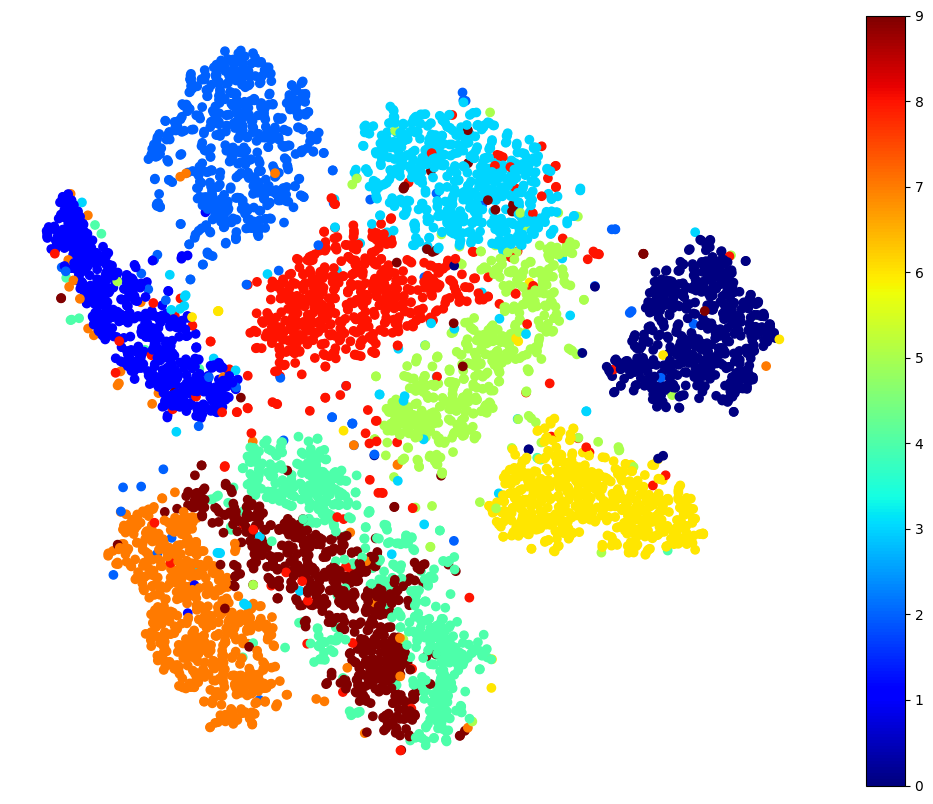

CPU times: user 525 ms, sys: 6.89 ms, total: 532 ms
Wall time: 538 ms


In [8]:
%%time
plt.figure(figsize=(13, 10))
plt.scatter(X_plot_tsne[:, 0], X_plot_tsne[:, 1], c = [int(i) for i in y] , cmap="jet")
plt.colorbar()
plt.axis('off')
plt.show()

An absolute beautiful image that shows you many information about the data that you can't observe in a higher dimension. Take for example


*   the numbers like 3 and 5 are overlapped together, which you can observe from the data because they are quite similar in the images
*   numbers like 0 and 1 are quite and well separated so it's hard for any missclassification to happen the following classifier can approximately achieve 100% Accuracy on 0, 1



# custom t-SNE implementation

# Sammon mapping

poorly coded old library, https://github.com/cots-lab/sammon-mapping/blob/main/sammon/sammon.py

func signature: def sammon(x, n = 2, display = 0, inputdist = 'raw', maxhalves = 20, maxiter = 500, tolfun = 1e-9, init = 'pca'):

this is so slow that i havent even seen the output

In [ ]:
%%time
# this library is old and slow and bad
# !pip install sammon-mapping
# from sammon import sammon 
# X_plot_sammon = sammon.sammon(x=X)
!pip install tqdm

import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize
from joblib import Parallel, delayed
import warnings
from tqdm.auto import tqdm

def sammon_mapping_multicore(X, n_components=2, max_iter=100, tol=1e-8, n_jobs=None, verbose=True):
    """
    Performs Sammon Mapping with multi-core gradient calculation.
    
    Parameters:
    -----------
    X : ndarray, shape (n_samples, n_features)
        Input data matrix
    n_components : int, default=2
        Dimension of the embedded space
    max_iter : int, default=100
        Maximum number of iterations
    tol : float, default=1e-8  # Tighter tolerance
    n_jobs : int or None, default=None
        Number of parallel jobs (None=1, -1=all cores)
    verbose : bool, default=True
        Whether to show progress bars
    
    Returns:
    --------
    y : ndarray, shape (n_samples, n_components)
        Embedded points
    """
    import time
    
    # Input validation
    X = np.asarray(X)
    if X.ndim != 2:
        raise ValueError("X must be a 2D array")
    
    n, n_features = X.shape
    if n_components <= 0:
        raise ValueError("n_components must be positive")
    
    if n < 3:
        warnings.warn("Sammon mapping may not work well with very few samples")
    
    if verbose:
        print(f"Sammon Mapping: {n} samples, {n_features} features -> {n_components} dimensions")
    
    # Calculate original distances
    if verbose:
        print("Calculating original distances...")
    D = squareform(pdist(X, 'euclidean'))

    # Handle zero distances - replace with small value but keep track
    epsilon = 1e-12
    D_safe = D.copy()
    
    # Create mask for valid distances (non-zero, non-diagonal)
    valid_mask = (D > epsilon) & (~np.eye(n, dtype=bool))
    
    # Check if we have enough valid distances
    valid_count = np.sum(valid_mask)
    if valid_count < n * (n-1) / 4:  # Less than half of possible pairs
        warnings.warn(f"Many zero distances detected: {valid_count}/{n*(n-1)//2} valid pairs")
    
    # For stress calculation, we'll only use valid distances
    # For gradient, we'll skip zero distances
    
    # Calculate constant C using only valid distances
    C = np.sum(D_safe * valid_mask) / 2  # Divide by 2 since we use upper triangle
    
    if C <= 0:
        raise ValueError("Invalid distance matrix: normalization factor must be positive")
    
    if verbose:
        print(f"Normalization constant C: {C:.6f}")
        print(f"Valid distance pairs: {valid_count}")
    
    # Better initialization
    from sklearn.decomposition import PCA
    try:
        y_init = PCA(n_components=n_components).fit_transform(X)
        if verbose:
            print("Using PCA for initialization")
    except:
        # Fallback to random initialization scaled by data
        data_std = np.std(X, axis=0).mean()
        y_init = np.random.normal(0, data_std * 0.1, (n, n_components))
        if verbose:
            print("Using random initialization")
    
    # Store iteration information
    iteration_count = [0]
    stress_history = []
    
    def sammon_stress(y_flat):
        """Calculate Sammon stress only"""
        y_current = y_flat.reshape((n, n_components))
        
        # Calculate current distances
        d = squareform(pdist(y_current, 'euclidean'))
        d_safe = d.copy()
        
        # Only compute stress for valid pairs (non-zero original distances)
        stress_terms = np.zeros_like(D_safe)
        
        # Vectorized computation for valid pairs only
        valid_indices = np.where(valid_mask)
        if len(valid_indices[0]) > 0:
            i_idx, j_idx = valid_indices
            D_vals = D_safe[i_idx, j_idx]
            d_vals = d_safe[i_idx, j_idx]
            
            # Safe computation - ensure no division by zero
            with np.errstate(divide='ignore', invalid='ignore'):
                terms = np.where(D_vals > epsilon, 
                               (D_vals - d_vals) ** 2 / D_vals, 
                               0.0)
            stress_terms[i_idx, j_idx] = terms
        
        # Sum only upper triangle to avoid double counting
        stress = (1.0 / C) * np.sum(np.triu(stress_terms, k=1))
        
        return stress
    
    def sammon_gradient(y_flat):
        """Calculate Sammon gradient only"""
        y_current = y_flat.reshape((n, n_components))
        
        # Calculate current distances
        d = squareform(pdist(y_current, 'euclidean'))
        d_safe = d.copy()
        
        def grad_row(i):
            grad_i = np.zeros(n_components)
            for j in range(n):
                # Skip diagonal and zero distances
                if i != j and valid_mask[i, j]:
                    D_ij = D_safe[i, j]
                    d_ij = max(d_safe[i, j], epsilon)  # Ensure no division by zero
                    
                    # Safe gradient calculation
                    if D_ij > epsilon and d_ij > epsilon:
                        ratio = (d_ij - D_ij) / (d_ij * D_ij)
                        grad_i += ratio * (y_current[i] - y_current[j])
            
            return grad_i * (-2.0 / C)  # Correct scaling and sign
        
        # Parallel gradient calculation
        if verbose:
            try:
                from joblib import parallel_config
                with parallel_config(verbose=6):  # Shows joblib's native progress
                    gradients = Parallel(n_jobs=n_jobs)(delayed(grad_row)(i) for i in range(n))
            except:
                # Method 2: Manual progress with batch updates
                print(f"Parallel gradient calculation (iteration {iteration_count[0] + 1})...")
                gradients = Parallel(n_jobs=n_jobs)(delayed(grad_row)(i) for i in range(n))
                print("Parallel calculation completed")
        else:
            gradients = Parallel(n_jobs=n_jobs)(delayed(grad_row)(i) for i in range(n))
        '''
        if n_jobs == 1:
            if verbose and iteration_count[0] % 10 == 0:  # Don't spam every iteration
                gradients = [grad_row(i) for i in tqdm(range(n), desc=f"Grad iter {iteration_count[0]+1}", leave=False)]
            else:
                gradients = [grad_row(i) for i in range(n)]
        else:
            if verbose and iteration_count[0] % 10 == 0:
                print(f"Parallel gradient (iter {iteration_count[0] + 1})...", end="\r")
            gradients = Parallel(n_jobs=n_jobs)(delayed(grad_row)(i) for i in range(n))
            if verbose and iteration_count[0] % 10 == 0:
                print(f"Parallel gradient (iter {iteration_count[0] + 1})... Done!")
        '''
        return np.array(gradients).flatten()
    
    def callback(xk):
        """Callback to track progress"""
        iteration_count[0] += 1
        current_stress = sammon_stress(xk)
        stress_history.append(current_stress)

        print(f"Iter {iteration_count[0]:3d}: Stress = {current_stress:.8f} (tol = {tol}, ratio = {current_stress/tol:.2f})")
        
        if verbose and (iteration_count[0] <= 10 or iteration_count[0] % 10 == 0 or iteration_count[0] == max_iter):
            grad_norm = np.linalg.norm(sammon_gradient(xk))
            print(f"Iter {iteration_count[0]:3d}: Stress = {current_stress:.8f}, GradNorm = {grad_norm:.8f}")
    
    # Optimization
    if verbose:
        print(f"Starting optimization (max {max_iter} iterations)...")
    
    # Test initial stress
    initial_stress = sammon_stress(y_init.flatten())
    if verbose:
        print(f"Initial stress: {initial_stress:.8f}")

    # Test the initial gradient
    initial_grad = sammon_gradient(y_init.flatten())
    grad_norm = np.linalg.norm(initial_grad)
    print(f"Initial gradient norm: {grad_norm}")
    print(f"Tolerance (PGTOL): {tol}")
    print(f"Ratio: {grad_norm/tol}")
    
    if grad_norm < tol:
        print("WARNING: Initial gradient is already below tolerance!")
        print("The optimizer will converge immediately.")
    
    # Test gradient correctness (optional)
    '''if verbose and n < 1000:  # Only for smaller datasets
        try:
            from scipy.optimize import check_grad
            grad_error = check_grad(sammon_stress, sammon_gradient, y_init.flatten())
            print(f"Gradient error: {grad_error:.8f}")
            if grad_error > 1e-4:
                warnings.warn("Gradient might be incorrect!")
        except:
            print("Gradient check skipped (too large or error)")'''

    from scipy.optimize import OptimizeResult

    class CallbackEnforcer:
        def __init__(self, callback, stress_func, grad_func):
            self.callback = callback
            self.stress_func = stress_func
            self.grad_func = grad_func
            self.iteration = 0
            
        def __call__(self, xk):
            self.iteration += 1
            stress = self.stress_func(xk)
            grad_norm = np.linalg.norm(self.grad_func(xk))
            print(f"ITERATION {self.iteration}: Stress = {stress:.8f}, GradNorm = {grad_norm:.8f}")
            return False  # Don't stop optimization
    
    # Use it like this:
    callback_obj = CallbackEnforcer(callback, sammon_stress, sammon_gradient)
    
    result = minimize(
        fun=sammon_stress,
        x0=y_init.flatten(),
        method='BFGS',
        jac=sammon_gradient,
        callback=callback_obj,  # Use the enforcer
        options={'gtol': tol, 'disp': True, 'maxiter': max_iter}
    )
    
    print(f"Optimization completed after {result.nit} iterations (callback was called {iteration_count[0]} times)")
    print(f"Final stress: {result.fun:.8f}")
    print(f"Success: {result.success}")
    print(f"Message: {result.message}")

    return result.x.reshape((n, n_components))

# Fit and transform the data
X_plot_sammon = sammon_mapping_multicore(X, n_jobs=5, tol=5e-8, verbose=True)

if X_plot_sammon is not None:
    plt.figure(figsize=(13, 10))
    plt.scatter(X_plot_sammon[:, 0], X_plot_sammon[:, 1], c=[int(i) for i in y], cmap="jet")
    plt.colorbar()
    plt.axis('off')
    plt.title("Sammon Mapping Projection")
    plt.show()
else:
    print("Sammon mapping returned None - check for errors above")

# Explicitly close parallel workers
from joblib.externals.loky import get_reusable_executor
get_reusable_executor().shutdown(wait=True)


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Sammon Mapping: 6000 samples, 784 features -> 2 dimensions
Calculating original distances...


/home/toshinari/Projects/jupyter-playground/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Normalization constant C: 46773962595.751160
Valid distance pairs: 35994000
Using PCA for initialization
Starting optimization (max 100 iterations)...
Initial stress: 0.43281439


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done  45 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 171 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 345 tasks      | elapsed:    6.3s
[Parallel(n_jobs=5)]: Done 571 tasks      | elapsed:    9.5s
[Parallel(n_jobs=5)]: Done 845 tasks      | elapsed:   13.3s
[Parallel(n_jobs=5)]: Done 1171 tasks      | elapsed:   17.9s
[Parallel(n_jobs=5)]: Done 1545 tasks      | elapsed:   23.3s
[Parallel(n_jobs=5)]: Done 1971 tasks      | elapsed:   29.3s
[Parallel(n_jobs=5)]: Done 2445 tasks      | elapsed:   35.9s
[Parallel(n_jobs=5)]: Done 2971 tasks      | elapsed:   43.2s
[Parallel(n_jobs=5)]: Done 3545 tasks      | elapsed:   51.5s
[Parallel(n_jobs=5)]: Done 4171 tasks      | elapsed:   59.7s
[Parallel(n_jobs=5)]: Done 4845 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done 5571 tasks      | elapsed:  1.3min
[

Initial gradient norm: 7.280290032256143e-06
Tolerance (PGTOL): 5e-08
Ratio: 145.60580064512286


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 302 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 650 tasks      | elapsed:    8.3s
[Parallel(n_jobs=5)]: Done 1102 tasks      | elapsed:   13.6s
[Parallel(n_jobs=5)]: Done 1650 tasks      | elapsed:   20.5s
[Parallel(n_jobs=5)]: Done 2302 tasks      | elapsed:   28.3s
[Parallel(n_jobs=5)]: Done 3050 tasks      | elapsed:   37.4s
[Parallel(n_jobs=5)]: Done 3902 tasks      | elapsed:   48.0s
[Parallel(n_jobs=5)]: Done 4850 tasks      | elapsed:   59.2s
[Parallel(n_jobs=5)]: Done 5902 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done 5991 out of 6000 | elapsed:  1.2min remaining:    0.1s
[Parallel(n_jobs=5)]: Done 6000 out of 6000 | elapsed:  1.2min finished


# isomap

In [ ]:
%%time
from sklearn.manifold import Isomap

# The n_neighbors parameter (k) is set to 12
isomap = Isomap(n_components=2, n_neighbors=12, eigen_solver='arpack', tol=1e-12, max_iter=100000)

# Fit and transform the data with Isomap
X_plot_isomap = isomap.fit_transform(X)

plt.figure(figsize=(13, 10))
# The `c=y` argument is often cleaner than a list comprehension
# if `y` is already a list or NumPy array of integers.
plt.scatter(X_plot_isomap[:, 0], X_plot_isomap[:, 1], c= [int(i) for i in y], cmap="jet")
plt.colorbar()
plt.axis('off')
plt.title(f"Isomap Projection with {isomap.n_neighbors} Neighbors")
plt.show()


# first diagramset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# =================== GLOBAL DEFAULTS ===================
N_POINTS = 800
HDIM     = 10
PERP     = 10.0
RHO      = 0.01
XS_DEF   = np.linspace(0.0, 8.0, 60)
YS_DEF   = np.linspace(0.0, 8.0, 60)
SCALE_K_DEF = 1000.0
# ======================================================

# =================== PANEL CONFIG ===================
PANEL_CFG = {
    "SNE": {
        "xs": XS_DEF,
        "ys": YS_DEF,
        "scale_k": SCALE_K_DEF,
        "clim": (0, 18),
        "title": "Gradient of SNE",
    },
    "UNI": {
        "xs": XS_DEF,
        "ys": YS_DEF,
        "scale_k": SCALE_K_DEF,
        "clim": (-4, 14),
        "title": "Gradient of UNI-SNE",
    },
    "TSNE": {
        "xs": XS_DEF,
        "ys": np.linspace(0.0, 8.0, 60),
        "scale_k": SCALE_K_DEF,
        "clim": (-1.0, 1.0),
        "title": "Gradient of t-SNE (Enhanced Contrast)",
        "early_exaggeration": 4.0,
        "gain": 3.0,
    },
}
# ======================================================

# ------------------ CORE UTILS ------------------
def pairwise_squared_distances(X):
    sumX = np.sum(X**2, axis=1, keepdims=True)
    D2 = sumX + sumX.T - 2 * (X @ X.T)
    np.fill_diagonal(D2, 0.0)
    return np.maximum(D2, 0.0)

def Hbeta(D2_row, beta):
    P = np.exp(-D2_row * beta)
    s = np.sum(P)
    if s <= 1e-300:
        return 0.0, np.zeros_like(P)
    P /= s
    H = -np.sum(P * np.log2(P + 1e-300))
    return H, P

def binary_search_sigma_for_perplexity(D2, target_perp, tol=1e-5, max_iter=50):
    n = D2.shape[0]
    P_cond = np.zeros((n, n))
    logU = np.log2(target_perp)
    for i in range(n):
        Di = D2[i].copy()
        Di[i] = np.inf
        beta_min, beta_max = -np.inf, np.inf
        beta = 1.0
        H, thisP = Hbeta(Di, beta)
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < max_iter:
            if Hdiff > 0:
                beta_min = beta
                beta = 2.0 * beta if np.isinf(beta_max) else 0.5 * (beta + beta_max)
            else:
                beta_max = beta
                beta = 0.5 * (beta + beta_min) if not np.isinf(beta_min) else beta / 2.0
            H, thisP = Hbeta(Di, beta)
            Hdiff = H - logU
            tries += 1
        P_cond[i] = thisP
    return P_cond

def symmetrize_joint(P_cond):
    n = P_cond.shape[0]
    P = (P_cond + P_cond.T) / (2.0 * n)
    np.fill_diagonal(P, 0.0)
    Z = np.sum(P)
    if Z > 0:
        P /= Z
    return P

def lowD_Q_gaussian(Y):
    D2 = pairwise_squared_distances(Y)
    num = np.exp(-D2)
    np.fill_diagonal(num, 0.0)
    Q = num / np.sum(num)
    return Q, D2

def lowD_Q_student_original(Y):
    D2 = pairwise_squared_distances(Y)
    num = 1.0 / (1.0 + D2)
    np.fill_diagonal(num, 0.0)
    Q = num / np.sum(num)
    return Q, D2

# ------------------ Precomputation ------------------
def precompute_Pij_for_xgrid(xs, n=N_POINTS, D=HDIM, perp=PERP, seed=123):
    rng = np.random.RandomState(seed)
    Pij = np.zeros(len(xs))
    X_bg = rng.randn(n, D)
    for k, x in enumerate(tqdm(xs, desc="P(x)")):
        X = X_bg.copy()
        X[0] = 0.0
        X[1] = 0.0; X[1, 0] = x
        D2 = pairwise_squared_distances(X)
        P_cond = binary_search_sigma_for_perplexity(D2, target_perp=perp)
        P = symmetrize_joint(P_cond)
        Pij[k] = P[0, 1]
    print(f"[DEBUG] P(x): min={Pij.min():.4e}, mean={Pij.mean():.4e}, max={Pij.max():.4e}")
    return Pij

def precompute_Qij_for_ygrid_gauss(ys, n=N_POINTS, seed=456):
    rng = np.random.RandomState(seed)
    Qij = np.zeros(len(ys))
    Y_bg = rng.randn(n, 2)
    for k, y in enumerate(tqdm(ys, desc="Q(y) Gaussian")):
        Y = Y_bg.copy()
        Y[0] = 0.0
        Y[1] = 0.0; Y[1, 0] = y
        Q, _ = lowD_Q_gaussian(Y)
        Qij[k] = Q[0, 1]
    print(f"[DEBUG] Q_gauss(y): min={Qij.min():.4e}, mean={Qij.mean():.4e}, max={Qij.max():.4e}")
    return Qij

def precompute_Qij_for_ygrid_t_original(ys, n=N_POINTS, seed=789):
    rng = np.random.RandomState(seed)
    Qij = np.zeros(len(ys))
    denom = np.zeros(len(ys))
    Y_bg = rng.randn(n, 2)
    for k, y in enumerate(tqdm(ys, desc="Q(y) t-SNE (orig Laurens)")):
        Y = Y_bg.copy()
        Y[0] = 0.0
        Y[1] = 0.0; Y[1, 0] = y
        Q, D2 = lowD_Q_student_original(Y)
        Qij[k] = Q[0, 1]
        denom[k] = 1.0 + D2[0, 1]
    print(f"[DEBUG] Q_t(y): min={Qij.min():.4e}, mean={Qij.mean():.4e}, max={Qij.max():.4e}")
    return Qij, denom

# =================== Build Heatmaps ===================
def build_heatmaps(n=N_POINTS, D=HDIM, perp=PERP, rho=RHO):
    xs_base = PANEL_CFG["SNE"]["xs"]
    Pij_x = precompute_Pij_for_xgrid(xs_base, n, D, perp)

    ys_sne = PANEL_CFG["SNE"]["ys"]
    ys_uni = PANEL_CFG["UNI"]["ys"]
    ys_tsn = PANEL_CFG["TSNE"]["ys"]

    Qij_y_g_SNE = precompute_Qij_for_ygrid_gauss(ys_sne, n)
    Qij_y_g_UNI = precompute_Qij_for_ygrid_gauss(ys_uni, n)
    Qij_y_t, denom_y_t = precompute_Qij_for_ygrid_t_original(ys_tsn, n)

    U_scalar = 1.0 / (n * (n - 1))

    Zs = np.zeros((len(ys_sne), len(xs_base)))
    Zu = np.zeros((len(ys_uni), len(xs_base)))
    Zt = np.zeros((len(ys_tsn), len(xs_base)))

    # ---- SNE ----
    for iy, y in enumerate(ys_sne):
        qg = Qij_y_g_SNE[iy]
        for ix, x in enumerate(xs_base):
            pij = Pij_x[ix]
            Zs[iy, ix] = 4.0 * (pij - qg) * y
    Zs = np.maximum(0.0, Zs)
    Zs *= PANEL_CFG["SNE"]["scale_k"]

    # ---- UNI-SNE ----
    for iy, y in enumerate(ys_uni):
        qg = Qij_y_g_UNI[iy]
        q_uni = (1 - rho) * qg + rho * U_scalar
        for ix, x in enumerate(xs_base):
            pij = Pij_x[ix]
            Zu[iy, ix] = 4.0 * (pij - q_uni) * y
    Zu *= PANEL_CFG["UNI"]["scale_k"]

    # ---- t-SNE (enhanced contrast version) ----
    ee   = PANEL_CFG["TSNE"]["early_exaggeration"]
    gain = PANEL_CFG["TSNE"]["gain"]

    sigma_high = 1.0
    student_c  = 1.0
    atten_y    = 0.6
    contrast   = 1.4   # increase dynamic range

    for iy, y in enumerate(ys_tsn):
        for ix, x in enumerate(xs_base):
            p = np.exp(-(x ** 2) / (2 * sigma_high ** 2))
            q = 1.0 / (1.0 + (y ** 2) / student_c)
            denom = 1.0 + (y ** 2) / student_c
            Zt[iy, ix] = contrast * gain * 4.0 * (ee * p - q) * (atten_y * y / denom)

    Zt *= PANEL_CFG["TSNE"]["scale_k"]
    # allow 0.5 extra saturation range beyond ±1
    Zt /= (np.max(np.abs(Zt)) / 1.5 + 1e-9)

    print(f"[DEBUG] scaled grad ranges:")
    print(f"  SNE : {Zs.min():.2f}..{Zs.max():.2f}")
    print(f"  UNI : {Zu.min():.2f}..{Zu.max():.2f}")
    print(f"  tSNE: {Zt.min():.2f}..{Zt.max():.2f}")

    return (xs_base, ys_sne, Zs), (xs_base, ys_uni, Zu), (xs_base, ys_tsn, Zt)

# =================== Plot ===================
def plot_gradients(sne_pack, uni_pack, tsn_pack):
    (xs_sne, ys_sne, Zs) = sne_pack
    (xs_uni, ys_uni, Zu) = uni_pack
    (xs_tsn, ys_tsn, Zt) = tsn_pack

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    opts = dict(origin='lower', interpolation='nearest', aspect='equal')

    im0 = axes[0].imshow(Zs, extent=[xs_sne[0], xs_sne[-1], ys_sne[0], ys_sne[-1]],
                         cmap='RdYlBu_r', **opts)
    im0.set_clim(*PANEL_CFG["SNE"]["clim"])
    axes[0].set_title(PANEL_CFG["SNE"]["title"])
    plt.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(Zu, extent=[xs_uni[0], xs_uni[-1], ys_uni[0], ys_uni[-1]],
                         cmap='RdYlBu_r', **opts)
    im1.set_clim(*PANEL_CFG["UNI"]["clim"])
    axes[1].set_title(PANEL_CFG["UNI"]["title"])
    plt.colorbar(im1, ax=axes[1])

    im2 = axes[2].imshow(Zt, extent=[xs_tsn[0], xs_tsn[-1], ys_tsn[0], ys_tsn[-1]],
                         cmap='RdYlBu_r', **opts)
    im2.set_clim(*PANEL_CFG["TSNE"]["clim"])
    axes[2].set_title(PANEL_CFG["TSNE"]["title"])
    plt.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    plt.show()

# =================== Main ===================
def main():
    sne_pack, uni_pack, tsn_pack = build_heatmaps()
    plot_gradients(sne_pack, uni_pack, tsn_pack)

if __name__ == "__main__":
    main()


### 01 Classifier

%%time
index_train_01 = [i for i in range(len(y_train)) if y_train[i] in ['0', '1']]
X_train_01 = X_train[index_train_01]
y_train_01 = y_train[index_train_01]
index_test_01 = [i for i in range(len(y_test)) if y_test[i] in ['0', '1']]
X_test_01 = X_test[index_test_01]
y_test_01 = y_test[index_test_01]

%%time
rnd_clf_01 = RandomForestClassifier()
t0 = time.time()
rnd_clf_01.fit(X_train_01, y_train_01)
print(rnd_clf_01.__class__.__name__, "Training time:", time.time() - t0)
print(rnd_clf_01.__class__.__name__, "Accuracy:", rnd_clf_01.score(X_test_01, y_test_01))

## PCA technique

%%time
pca = PCA(n_components=2)
X_plot_pca = pca.fit_transform(X)

%%time
plt.figure(figsize=(13, 10))
plt.scatter(X_plot_pca[:, 0], X_plot_pca[:, 1], c = [int(i) for i in y] , cmap="jet")
plt.colorbar()
plt.axis('off')
plt.show()

A huge diffience between the PCA and TSNE which you can see from the images that the TSNE gives better visulization

Note that the below plot about the preserved variance and the n_component used by the PCA. Note that we got an elbow for the plot approximately 100 which you can conclude that this the best number of principle components.

%%time
pca_draw = PCA()
pca_draw.fit(X_train)
cum_sum = np.cumsum(pca_draw.explained_variance_ratio_)
plt.figure(figsize=(13, 10))
plt.plot(list(range(len(cum_sum))), cum_sum)
plt.ylabel("Observed Variance")
plt.xlabel("Principle Components")
plt.show()

## Locally Linear Embedding (LLE)

In [ ]:
%%time
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_neighbors=12, n_components=2)
X_plot_lle = lle.fit_transform(X)

In [ ]:
%%time
plt.figure(figsize=(13, 10))
plt.scatter(X_plot_lle[:, 0], X_plot_lle[:, 1], c = [int(i) for i in y] , cmap="jet")
plt.colorbar()
plt.axis('off')
plt.show()

## Linear Discriminant Analysis

%%time
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
X_plot_lda = lda.fit_transform(X, y)

%%time
plt.figure(figsize=(13, 10))
plt.scatter(X_plot_lda[:, 0], X_plot_lda[:, 1], c = [int(i) for i in y] , cmap="jet")
plt.colorbar()
plt.axis('off')
plt.show()

## Multidimensional scaling(MDS)

The MDS takes a lot of time in order to fit the data so will try it only on 2000 instance

#%%time
#idx = np.random.permutation(60000)[:2000]
#X_mds = mnist['data'][idx]
#y_mds = mnist['target'][idx]

%%time
from sklearn.manifold import MDS
mds = MDS()
X_plot_mds = mds.fit_transform(X_mds)

%%time
plt.figure(figsize=(13, 10))
plt.scatter(X_plot_mds[:, 0], X_plot_mds[:, 1], c = [int(i) for i in y_mds] , cmap="jet")
plt.colorbar()
plt.axis('off')
plt.show()

As you can see a lot of data is overlapped and you can't distinguish any of the classes so it's not the best for the visualization at least for this data set

# Conclusion


Using the  Dimeninality education gives us the  ability to see our data better training and visualization and many other features you can try to use like PCA kernel, IncrementalPCA or many other techniques that you can find.


Leave me a comment I totally appreciate your feedback and it's totally helpful for me 🥰 🥰 🥰